# Understanding GRUs with PyTorch Lightning

This notebook provides a comprehensive introduction to Gated Recurrent Units (GRUs) using PyTorch Lightning.

## Table of Contents
1. [What are GRUs?](#what-are-grus)
2. [GRU Architecture](#gru-architecture)
3. [GRUs vs LSTMs](#grus-vs-lstms)
4. [Implementation with PyTorch Lightning](#implementation)
5. [Practical Example: Sequence Prediction](#example)
6. [Training and Evaluation](#training)
7. [Visualization](#visualization)

In [5]:
# Install required packages
# !pip install torch lightning matplotlib numpy

In [6]:
import torch
import torch.nn as nn
import pytorch_lightning as L
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Lightning version: {L.__version__}")

PyTorch version: 2.7.1
Lightning version: 2.5.2


## 1. What are GRUs? <a name="what-are-grus"></a>

**Gated Recurrent Units (GRUs)** are a type of recurrent neural network (RNN) architecture designed to capture long-term dependencies in sequential data while addressing the vanishing gradient problem.

### Key Properties:
- **Gating mechanisms**: Control information flow through the network
- **Simpler than LSTMs**: Fewer parameters, faster training
- **Effective for many tasks**: Text, time series, speech, etc.
- **Memory efficient**: Maintains hidden state without separate cell state

### Use Cases:
- Natural Language Processing (NLP)
- Time series forecasting
- Speech recognition
- Music generation
- Video analysis

## 2. GRU Architecture <a name="gru-architecture"></a>

A GRU cell has two gates:

### 1. Reset Gate (r_t)
Controls how much of the previous hidden state to forget:
```
r_t = σ(W_r · [h_{t-1}, x_t] + b_r)
```

### 2. Update Gate (z_t)
Controls how much of the previous hidden state to keep:
```
z_t = σ(W_z · [h_{t-1}, x_t] + b_z)
```

### 3. Candidate Hidden State (h̃_t)
Computes new candidate values:
```
h̃_t = tanh(W_h · [r_t ⊙ h_{t-1}, x_t] + b_h)
```

### 4. Final Hidden State (h_t)
Combines old and new information:
```
h_t = (1 - z_t) ⊙ h_{t-1} + z_t ⊙ h̃_t
```

Where:
- `σ` is the sigmoid function
- `⊙` is element-wise multiplication
- `x_t` is the input at time t
- `h_t` is the hidden state at time t

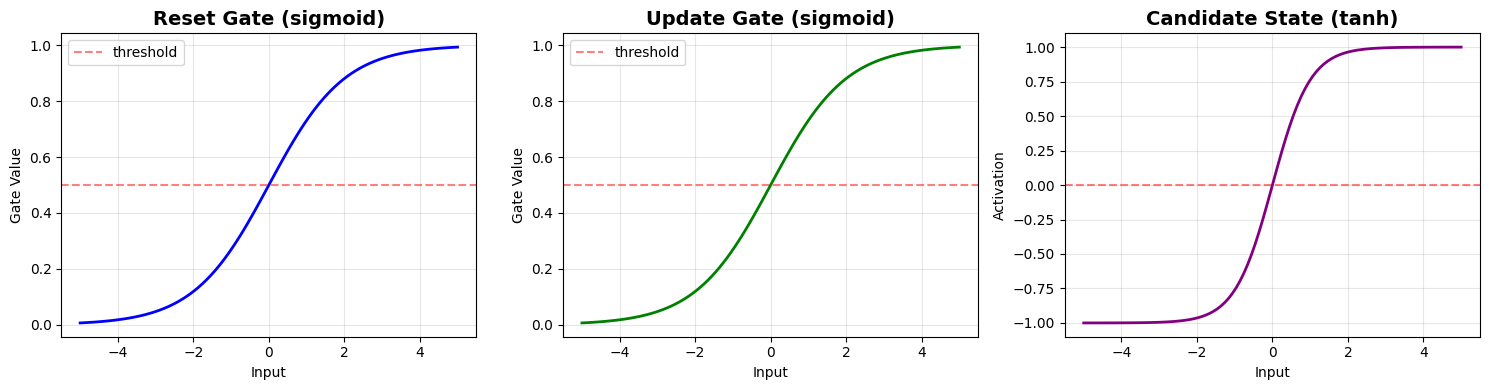

In [7]:
# Visualize GRU gates behavior
def visualize_gru_gates():
    """Visualize how GRU gates work with example values."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Reset gate: controls memory from previous timestep
    x = np.linspace(-5, 5, 100)
    reset_gate = 1 / (1 + np.exp(-x))  # sigmoid
    axes[0].plot(x, reset_gate, 'b-', linewidth=2)
    axes[0].set_title('Reset Gate (sigmoid)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Input')
    axes[0].set_ylabel('Gate Value')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='threshold')
    axes[0].legend()
    
    # Update gate: controls how much to update
    update_gate = 1 / (1 + np.exp(-x))  # sigmoid
    axes[1].plot(x, update_gate, 'g-', linewidth=2)
    axes[1].set_title('Update Gate (sigmoid)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Input')
    axes[1].set_ylabel('Gate Value')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='threshold')
    axes[1].legend()
    
    # Candidate state: tanh activation
    candidate = np.tanh(x)
    axes[2].plot(x, candidate, 'purple', linewidth=2)
    axes[2].set_title('Candidate State (tanh)', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Input')
    axes[2].set_ylabel('Activation')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

visualize_gru_gates()

## 3. GRUs vs LSTMs <a name="grus-vs-lstms"></a>

| Feature | GRU | LSTM |
|---------|-----|------|
| Gates | 2 (reset, update) | 3 (input, forget, output) |
| Parameters | Fewer | More |
| Memory | Single hidden state | Hidden state + cell state |
| Training Speed | Faster | Slower |
| Performance | Competitive on many tasks | Often better on complex tasks |
| Use When | Limited data, need speed | Complex sequences, more data |

**Rule of Thumb**: Start with GRU for faster experimentation, switch to LSTM if you need more capacity.

## 4. Implementation with PyTorch Lightning <a name="implementation"></a>

Let's implement a GRU-based model using PyTorch Lightning. We'll create a flexible module that can be used for various sequence tasks.

In [8]:
class GRUModel(L.LightningModule):
    """A flexible GRU model implemented with PyTorch Lightning.
    
    Args:
        input_size: Number of input features
        hidden_size: Number of hidden units in GRU
        num_layers: Number of stacked GRU layers
        output_size: Number of output features
        dropout: Dropout probability (applied between layers if num_layers > 1)
        bidirectional: Whether to use bidirectional GRU
        learning_rate: Learning rate for optimizer
    """
    
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int = 1,
        output_size: int = 1,
        dropout: float = 0.0,
        bidirectional: bool = False,
        learning_rate: float = 1e-3,
    ):
        super().__init__()
        self.save_hyperparameters()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True,  # (batch, seq, feature)
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)
        
        # Loss function
        self.criterion = nn.MSELoss()
    
    def forward(self, x: torch.Tensor, hidden: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch, seq_len, input_size)
            hidden: Initial hidden state (optional)
            
        Returns:
            output: Predictions of shape (batch, seq_len, output_size)
            hidden: Final hidden state
        """
        # GRU forward pass
        # gru_out: (batch, seq_len, hidden_size * num_directions)
        # hidden: (num_layers * num_directions, batch, hidden_size)
        gru_out, hidden = self.gru(x, hidden)
        
        # Apply output layer to all timesteps
        output = self.fc(gru_out)
        
        return output, hidden
    
    def training_step(self, batch, batch_idx):
        """Training step."""
        x, y = batch
        y_hat, _ = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        """Validation step."""
        x, y = batch
        y_hat, _ = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        """Configure optimizer."""
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
    
    def predict_sequence(self, x: torch.Tensor, steps: int) -> torch.Tensor:
        """Predict multiple steps into the future.
        
        Args:
            x: Initial sequence of shape (batch, seq_len, input_size)
            steps: Number of steps to predict
            
        Returns:
            predictions: Tensor of shape (batch, steps, output_size)
        """
        self.eval()
        with torch.no_grad():
            predictions = []
            hidden = None
            
            # Process initial sequence
            _, hidden = self(x, hidden)
            
            # Get last output as first input
            current_input = x[:, -1:, :]
            
            # Predict future steps
            for _ in range(steps):
                output, hidden = self(current_input, hidden)
                predictions.append(output)
                current_input = output
            
            return torch.cat(predictions, dim=1)

print("GRUModel class defined successfully!")

GRUModel class defined successfully!


## 5. Practical Example: Sine Wave Prediction <a name="example"></a>

Let's use our GRU model to learn and predict a sine wave pattern. This is a classic sequence prediction task that demonstrates how GRUs can capture temporal patterns.

Generating sine wave data...
Training data shape: X=torch.Size([800, 50, 1]), y=torch.Size([800, 10, 1])
Validation data shape: X=torch.Size([200, 50, 1]), y=torch.Size([200, 10, 1])


/var/folders/wz/x29jb7_x5rdc_5dcjr4qnhg00000gn/T/ipykernel_16315/2093413462.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  X = torch.FloatTensor(X).unsqueeze(-1)  # Add feature dimension


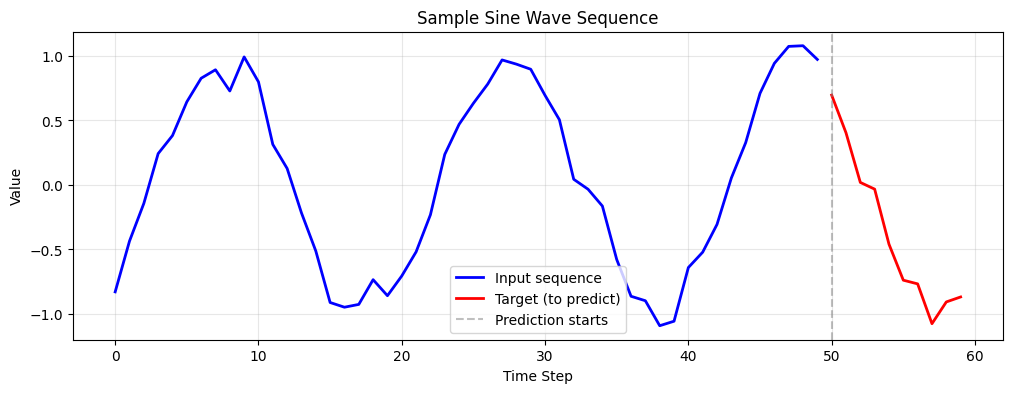

In [9]:
def generate_sine_wave_data(
    n_samples: int = 1000,
    seq_length: int = 50,
    prediction_length: int = 10,
    frequency: float = 0.05,
    noise_std: float = 0.1,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Generate sine wave sequences for training.
    
    Args:
        n_samples: Number of sequences to generate
        seq_length: Length of input sequence
        prediction_length: Length of target sequence
        frequency: Frequency of sine wave
        noise_std: Standard deviation of Gaussian noise
        
    Returns:
        X: Input sequences (n_samples, seq_length, 1)
        y: Target sequences (n_samples, prediction_length, 1)
    """
    X = []
    y = []
    
    for _ in range(n_samples):
        # Random starting point
        start = np.random.uniform(0, 100)
        
        # Generate sequence
        t = np.arange(start, start + seq_length + prediction_length)
        signal = np.sin(2 * np.pi * frequency * t)
        
        # Add noise
        signal += np.random.normal(0, noise_std, len(signal))
        
        # Split into input and target
        X.append(signal[:seq_length])
        y.append(signal[seq_length:seq_length + prediction_length])
    
    X = torch.FloatTensor(X).unsqueeze(-1)  # Add feature dimension
    y = torch.FloatTensor(y).unsqueeze(-1)
    
    return X, y

# Generate data
print("Generating sine wave data...")
X_train, y_train = generate_sine_wave_data(n_samples=800, seq_length=50, prediction_length=10)
X_val, y_val = generate_sine_wave_data(n_samples=200, seq_length=50, prediction_length=10)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Validation data shape: X={X_val.shape}, y={y_val.shape}")

# Visualize sample
plt.figure(figsize=(12, 4))
sample_idx = 0
plt.plot(range(50), X_train[sample_idx].numpy(), 'b-', label='Input sequence', linewidth=2)
plt.plot(range(50, 60), y_train[sample_idx].numpy(), 'r-', label='Target (to predict)', linewidth=2)
plt.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='Prediction starts')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Sample Sine Wave Sequence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 25
Number of validation batches: 7


## 6. Training and Evaluation <a name="training"></a>

Now let's train our GRU model and see how well it learns to predict the sine wave!

In [11]:
# Initialize model
model = GRUModel(
    input_size=1,
    hidden_size=64,
    num_layers=2,
    output_size=1,
    dropout=0.2,
    bidirectional=False,
    learning_rate=1e-3,
)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
GRUModel(
  (gru): GRU(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (criterion): MSELoss()
)

Total parameters: 37,889


In [12]:
# Configure trainer
trainer = L.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    enable_model_summary=True,
    log_every_n_steps=10,
)

# Train the model
print("Starting training...")
trainer.fit(model, train_loader, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting training...


/Users/tsilva/repos/tsilva/gymnasium-solver/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | gru       | GRU     | 37.8 K | train
1 | fc        | Linear  | 65     | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
37.9 K    Trainable params
0         Non-trainable params
37.9 K    Total params
0.152     Total estimated model params size (MB)
3         Modules in train mode
0         Module

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/tsilva/repos/tsilva/gymnasium-solver/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/tsilva/repos/tsilva/gymnasium-solver/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 10, 1])) that is different to the input size (torch.Size([32, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (50) must match the size of tensor b (10) at non-singleton dimension 1

## 7. Visualization and Results <a name="visualization"></a>

Let's visualize how well our trained GRU model performs on predicting future values.

In [ ]:
# Make predictions on validation set
model.eval()
with torch.no_grad():
    # Get predictions for all validation samples
    val_predictions = []
    val_targets = []
    
    for x_batch, y_batch in val_loader:
        y_pred, _ = model(x_batch)
        val_predictions.append(y_pred)
        val_targets.append(y_batch)
    
    val_predictions = torch.cat(val_predictions, dim=0)
    val_targets = torch.cat(val_targets, dim=0)

# Calculate metrics
mse = nn.MSELoss()(val_predictions, val_targets)
mae = torch.mean(torch.abs(val_predictions - val_targets))

print(f"Validation Metrics:")
print(f"  MSE: {mse:.6f}")
print(f"  MAE: {mae:.6f}")

In [ ]:
# Visualize predictions on multiple samples
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i in range(4):
    idx = np.random.randint(0, len(X_val))
    
    # Get input, target, and prediction
    x_sample = X_val[idx:idx+1]
    y_true = y_val[idx].numpy()
    
    with torch.no_grad():
        y_pred, _ = model(x_sample)
        y_pred = y_pred[0].numpy()
    
    # Plot
    ax = axes[i]
    input_range = range(50)
    pred_range = range(50, 60)
    
    ax.plot(input_range, x_sample[0].numpy(), 'b-', label='Input', linewidth=2, alpha=0.7)
    ax.plot(pred_range, y_true, 'g-', label='True', linewidth=2, marker='o')
    ax.plot(pred_range, y_pred, 'r--', label='Predicted', linewidth=2, marker='x')
    ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.set_title(f'Sample {idx + 1}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('GRU Predictions on Validation Set', y=1.02, fontsize=16, fontweight='bold')
plt.show()

In [ ]:
# Multi-step prediction (predicting further into the future)
print("Testing multi-step prediction...\n")

test_sample = X_val[0:1]  # Use first validation sample
future_steps = 20  # Predict 20 steps ahead

with torch.no_grad():
    future_pred = model.predict_sequence(test_sample, steps=future_steps)

# Visualize
plt.figure(figsize=(14, 5))
plt.plot(range(50), test_sample[0].numpy(), 'b-', label='Input sequence', linewidth=2)
plt.plot(range(50, 50 + future_steps), future_pred[0].numpy(), 'r--', 
         label=f'Predicted {future_steps} steps', linewidth=2, marker='o', markersize=4)
plt.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='Prediction starts')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Multi-Step Prediction with GRU', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Successfully predicted {future_steps} steps into the future!")

## Key Takeaways

1. **GRUs are powerful**: They can learn complex temporal patterns with fewer parameters than LSTMs

2. **Gating mechanisms**: The reset and update gates allow the network to selectively remember and forget information

3. **PyTorch Lightning**: Makes training clean and organized with minimal boilerplate

4. **Sequence prediction**: GRUs excel at tasks where past context informs future predictions

5. **Multi-step forecasting**: The model can be used recursively to predict multiple steps into the future

## Exercises

Try these modifications to deepen your understanding:

1. **Experiment with architecture**:
   - Try different `hidden_size` values (32, 128, 256)
   - Test more layers (`num_layers=3, 4`)
   - Enable bidirectional GRU (`bidirectional=True`)

2. **Different tasks**:
   - Time series prediction (stock prices, weather)
   - Text generation (character-level or word-level)
   - Music generation

3. **Compare with LSTM**:
   - Replace GRU with LSTM in the model
   - Compare training time and performance

4. **Regularization techniques**:
   - Add dropout to prevent overfitting
   - Try gradient clipping
   - Implement early stopping

5. **Advanced features**:
   - Attention mechanisms
   - Sequence-to-sequence architectures
   - Teacher forcing during training

## Resources

- [Original GRU Paper](https://arxiv.org/abs/1406.1078)
- [PyTorch GRU Documentation](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
- [PyTorch Lightning Documentation](https://lightning.ai/docs/pytorch/stable/)
- [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)